<h1 style="text-align: center;">AAE 590 Surrogate Methods</h1>

## Global Optimization

This notebook supports material covered in the class for global optimization. We will be using `scipy.optimize` module. Following are the topics covered:

1. [Multi-start gradient based optimization](#Multi-start-gradient-based-optimization)
2. [Differential evolution](#Differential-evolution)

<font color='red'>**Please run the below block of code before you run any other block**</font> - it imports all the packages needed for this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import minimize
import matplotlib.colors as colors

Consider the following fourth-order smooth multimodal function (also know as jones function):

$$
    f(x_1, x_2) = x_1^4 + x_2^4 - 4x_1^3 - 3x_2^3 + 2x_1^2 + 2x_1x_2
$$

As we have been doing in previous notebooks, we will plot the function contour first. It is very inmportant to have some insights/understanding of the design space. Below block of code defines a python function which returns the value of jones function at any given $x$.

In [2]:
def jones_function(x):
    """
        Function to evaluate values of jones function at any given x.
        
        Input:
        x - 1d numpy array containing only two entries. First entry is x1
        and 2nd entry is x2.
    """
    
    x1 = x[0]
    x2 = x[1]
    
    return x1**4 + x2**4 - 4*x1**3 - 3*x2**3 + 2*x1**2 + 2*x1*x2

Below block of code plots the contour of the function

Text(0.5, 1.0, 'Jones Function')

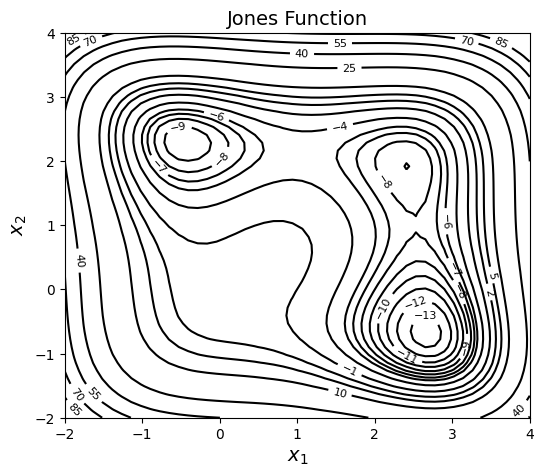

In [3]:
# Defining x and y values
x = np.linspace(-2,4,50)
y = np.linspace(-2,4,50)

# Creating a mesh at which values and 
# gradient will be evaluated and plotted
X, Y = np.meshgrid(x, y)

# Evaluating the function values at meshpoints
x1 = X.reshape(-1,)
x2 = Y.reshape(-1,)
Z = np.zeros_like(x1)

# Calculating function value at each grid point
for i in range(len(x1)):
        Z[i] = jones_function(np.array([x1[i],x2[i]]))

Z = Z.reshape(X.shape)
        
# Denoting at which level to add contour lines
levels = np.arange(-13,-5,1)
levels = np.concatenate((levels, np.arange(-4, 8, 3)))
levels = np.concatenate((levels, np.arange(10, 100, 15)))

# Plotting the contours
fig, ax = plt.subplots(figsize=(6,5))
CS = ax.contour(X, Y, Z, levels=levels, colors="k", linestyles="solid")
ax.clabel(CS, inline=1, fontsize=8)
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Jones Function", fontsize=14)

**Note**: For the jones function, a logscaled filled contour is needed to better visualize the design space. But there are many negative function values in the region and it is not possibile to take log of negative values. So, only line contours are plotted.

Before starting with global optimization, we will do simple unconstrained gradient based optimization with different starting points and note the results. Below block of code defines various required functions.

In [4]:
def jones_opt_history(x):
    """
        Function which is called after every iteration of optimization.
        It stores the value of x1, x2, and function value which is later
        for plotting convergence history.
        
        Input: 
        x - 1d numpy array which contains current x value
        convergence - represents the fractional value of the population convergence
        Output: None
    """
    
    history["x1"].append(x[0])
    history["x2"].append(x[1])
    history["f"].append(jones_function(x))
    
def jones_func_opt_plots(history, starting_point):
    """
        Function used for plotting the results of the optimization.
        
        Input: 
        history - A dictionary which contains three key-value pairs - x1, x2, and f.
        Each of this pair should be a list which contains values of 
        the respective quantity at each iteration. Look at the usage of this
        function in following blocks for better understanding.
        
        method - A string which denotes the method used for optimization.
        It is only used in the title of the plots.
    """
    
    # Number of iterations.
    # Subtracting 1, since it also contains starting point
    num_itr = len(history["x1"]) - 1
    
    # Defining x and y values
    x = np.linspace(-2,4,100)
    y = np.linspace(-2,4,100)

    # Creating a mesh at which values 
    # will be evaluated and plotted
    X, Y = np.meshgrid(x, y)

    # Evaluating the function values at meshpoints
    x1 = X.reshape(-1,)
    x2 = Y.reshape(-1,)
    Z = np.zeros_like(x1)

    # Calculating function value at each grid point
    for i in range(len(x1)):
            Z[i] = jones_function(np.array([x1[i],x2[i]]))

    Z = Z.reshape(X.shape)

    # Plotting the convergence history
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(np.arange(num_itr+1), history["x1"], "k", marker=".", label="$x_1$")
    ax.plot(np.arange(num_itr+1), history["x2"], "b", marker=".", label="$x_2$")
    ax.plot(np.arange(num_itr+1), history["f"], "g", marker=".", label="$f$")
    ax.set_xlabel("Iterations", fontsize=14)
    ax.set_xlim(left=0, right=num_itr)
    ax.set_ylabel("Quantities", fontsize=14)
    ax.grid()
    ax.legend(fontsize=12)
    ax.set_title("Convergence history - " + method, fontsize=14)
    
    # Denoting at which level to add contour lines
    levels = np.arange(-13,-5,1)
    levels = np.concatenate((levels, np.arange(-4, 8, 3)))
    levels = np.concatenate((levels, np.arange(10, 100, 15)))

    # Plotting the contours
    fig, ax = plt.subplots(figsize=(6,5))
    CS = ax.contour(X, Y, Z, levels=levels, colors="k", linestyles="solid")
    ax.clabel(CS, inline=1, fontsize=8)
    ax.plot(history["x1"], history["x2"], "k--", marker=".", label="Path", zorder=100.0)
    ax.scatter(x0[0], x0[1], label="Starting point", c="red", zorder=10.0)
    ax.scatter(result.x[0], result.x[1], label="Final point", c="magenta", zorder=10.0)
    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("$x_2$", fontsize=14)
    ax.set_title("Path of optimizer - starting point: {}".format(starting_point), fontsize=14)
    ax.legend()

    plt.show()

Below block of code performs gradient based optimization with different starting points:

Optimization terminated successfully.
         Current function value: -9.031204
         Iterations: 9
         Function evaluations: 36
         Gradient evaluations: 12
Value of x1 at optimum: 2.4238786497394718
Value of x2 at optimum: 1.9218850699097503


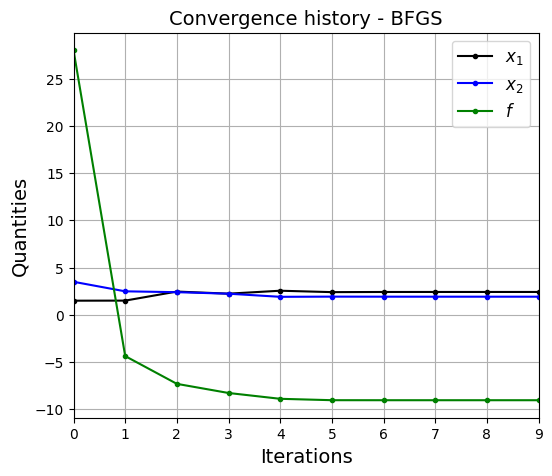

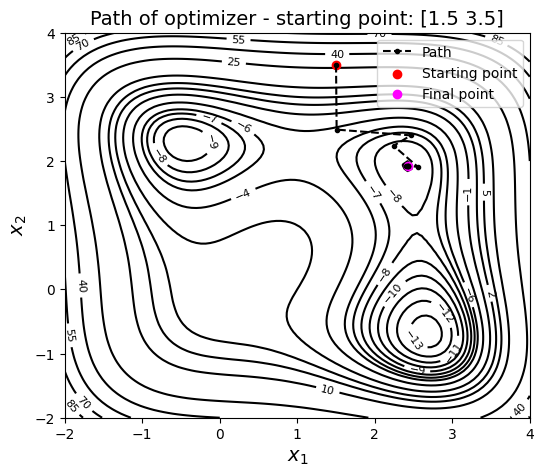

Optimization terminated successfully.
         Current function value: -9.776964
         Iterations: 7
         Function evaluations: 48
         Gradient evaluations: 16
Value of x1 at optimum: -0.44947767686813583
Value of x2 at optimum: 2.2927527005855954


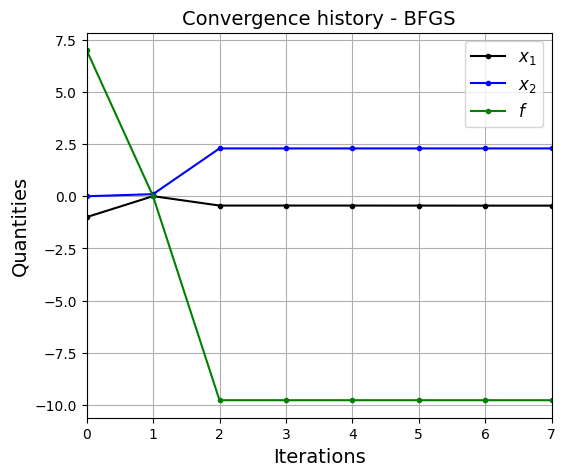

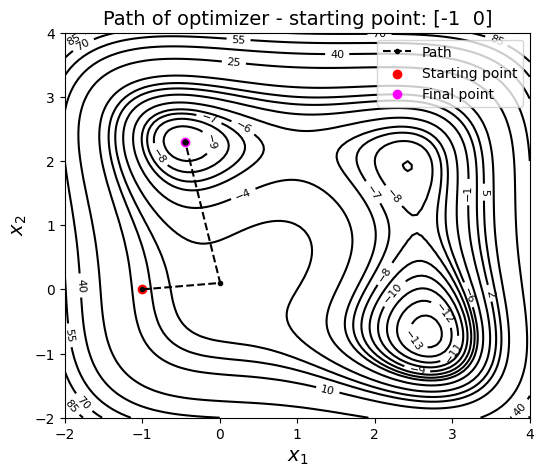

Optimization terminated successfully.
         Current function value: -13.532035
         Iterations: 22
         Function evaluations: 153
         Gradient evaluations: 51
Value of x1 at optimum: 2.6732085924175255
Value of x2 at optimum: -0.6758850426022831


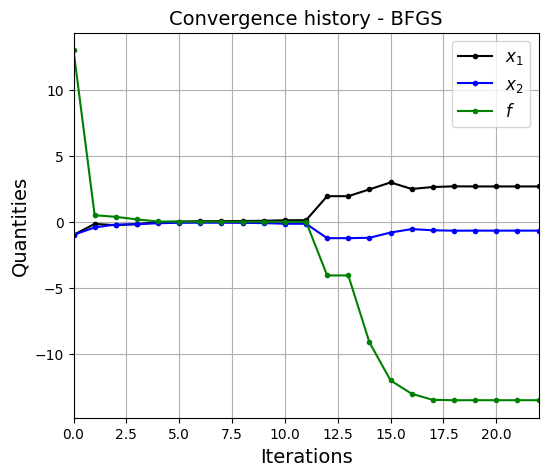

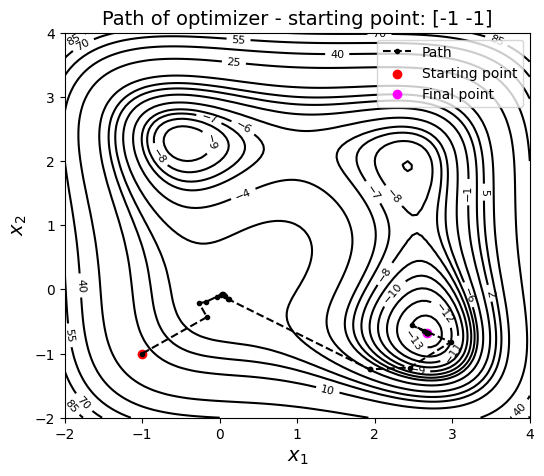

In [5]:
# Solver
method = "BFGS"

# Defines which finite difference scheme to use. Possible values are:
# "2-point" - forward/backward difference
# "3-point" - central difference
# "cs" - complex step
jac = "2-point"

# Solver options
options ={
    "disp": True
}

################################ Starting point 1
x0 = np.array([1.5, 3.5])

# Defining dict for storing history of optimization
history = {}
history["x1"] = [x0[0]]
history["x2"] = [x0[1]]
history["f"] = [jones_function(x0)]

# Minimize the function
result = minimize(fun=jones_function, x0=x0, method=method, jac=jac, callback=jones_opt_history, options=options)

# Print value of x
print("Value of x1 at optimum: {}".format(result.x[0]))
print("Value of x2 at optimum: {}".format(result.x[1]))

# Convergence plots
jones_func_opt_plots(history, starting_point=x0)

################################ Starting point 2
x0 = np.array([-1, 0])

# Defining dict for storing history of optimization
history = {}
history["x1"] = [x0[0]]
history["x2"] = [x0[1]]
history["f"] = [jones_function(x0)]

# Minimize the function
result = minimize(fun=jones_function, x0=x0, method=method, jac=jac, callback=jones_opt_history, options=options)

# Print value of x
print("Value of x1 at optimum: {}".format(result.x[0]))
print("Value of x2 at optimum: {}".format(result.x[1]))

# Convergence plots
jones_func_opt_plots(history, starting_point=x0)

################################ Starting point 3
x0 = np.array([-1, -1])

# Defining dict for storing history of optimization
history = {}
history["x1"] = [x0[0]]
history["x2"] = [x0[1]]
history["f"] = [jones_function(x0)]

# Minimize the function
result = minimize(fun=jones_function, x0=x0, method=method, jac=jac, callback=jones_opt_history, options=options)

# Print value of x
print("Value of x1 at optimum: {}".format(result.x[0]))
print("Value of x2 at optimum: {}".format(result.x[1]))

# Convergence plots
jones_func_opt_plots(history, starting_point=x0)

You can notice that with different starting points, the optimum obtained is different. This confirms the multi-modal nature of design space and the need for global optimization algorithm.

### Multi-start gradient based optimization

As described in the lecture, it involves gradient-based optimization with different starting points and finally selecting the best (either maximum or minmum depending on the problem) value. Below block of code performs gradient based optimization with 9 different starting points and prints the results. Read comments in the code for more details.

In [6]:
# Solver
method = "BFGS"

# Defines which finite difference scheme to use. Possible values are:
# "2-point" - forward/backward difference
# "3-point" - central difference
# "cs" - complex step
jac = "2-point"

# Solver options
options ={
    "disp": False
}

# Creating starting points
num_pts = 3 # number of points in each direction
x = np.linspace(-1.5, 3.5, num_pts)
y = np.linspace(-1.5, 3.5, num_pts)
X,Y = np.meshgrid(x,y)

# Reshaping the array into 1D array
# Total points be square of num_pts
X = X.reshape(-1,)
Y = Y.reshape(-1,)

# Performing multi-start optimization
for index in range(len(X)):
    starting_point = np.array([X[index], Y[index]])
    
    # Minimize the function
    result = minimize(fun=jones_function, x0=starting_point, method=method, jac=jac, options=options)

    # Checking if the optimum found is better than current best point
    if index == 0:
        # Storing the best point
        best_point = result.x
        best_obj = jones_function(result.x)
    else:
        if jones_function(result.x) < best_obj:
            best_point = result.x
            best_obj = jones_function(result.x)
            
    print("Iteration {}:".format(index+1))
    print("Starting point: {}, Optimum found at: {}".format(result.x, jones_function(result.x)))
    
print("\nResult:")
print("{} is the best value found at x1 = {} and x2 = {}.".format(best_obj, best_point[0], best_point[1]))

Iteration 1:
Starting point: [-0.44947767  2.2927527 ], Optimum found at: -9.776963671379727
Iteration 2:
Starting point: [ 2.6732083  -0.67588499], Optimum found at: -13.53203478165186
Iteration 3:
Starting point: [ 2.67320852 -0.67588494], Optimum found at: -13.532034781652612
Iteration 4:
Starting point: [-0.44947767  2.29275273], Optimum found at: -9.77696367137972
Iteration 5:
Starting point: [2.42387823 1.92188478], Optimum found at: -9.031204451296723
Iteration 6:
Starting point: [ 2.67320836 -0.67588491], Optimum found at: -13.532034781652165
Iteration 7:
Starting point: [-0.44947765  2.29275263], Optimum found at: -9.776963671379637
Iteration 8:
Starting point: [-0.44947757  2.29275279], Optimum found at: -9.776963671379535
Iteration 9:
Starting point: [2.42387923 1.92188489], Optimum found at: -9.031204451295679

Result:
-13.532034781652612 is the best value found at x1 = 2.673208518793241 and x2 = -0.6758849352700709.


### Differential evolution

[Differential evolution](https://en.wikipedia.org/wiki/Differential_evolution) is a global optimization algorithm available in `scipy.optimize` module. There are various parameters for this method, please read the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) for more details.

Below block of code defines couple of functions which are used during optimization. Read comments in the code for more details.

In [7]:
def jones_global_opt_history(x, convergence):
    """
        Function which is called after every iteration of optimization.
        It stores the value of x1, x2, function value, and convergence which is
        later used for plotting convergence history.
        
        Note: This function is slightly different from the one used for gradient
        based optimization. There is one more variable which is given to optimizer.
        
        Input: 
        x - 1d numpy array which contains current x value
        convergence - represents the fractional value of the population convergence
        Output: None
    """
    
    history["x1"].append(x[0])
    history["x2"].append(x[1])
    history["f"].append(jones_function(x))
    history["convergence"].append(convergence)
    
def jones_func_global_opt_plots(history):
    """
        Function used for plotting the results of the optimization.
        
        Input: 
        history - A dictionary which contains three key-value pairs - x1, x2, and f.
        Each of this pair should be a list which contains values of 
        the respective quantity at each iteration. Look at the usage of this
        function in following blocks for better understanding.
        
        method - A string which denotes the method used for optimization.
        It is only used in the title of the plots.
    """
    
    # Number of iterations
    num_itr = len(history["x1"])
    
    # Defining x and y values
    x = np.linspace(-4,4,50)
    y = np.linspace(-4,4,50)
    
    # Creating a mesh at which values 
    # will be evaluated and plotted
    X, Y = np.meshgrid(x, y)
    
    # Evaluating the function values at meshpoints
    x1 = X.reshape(-1,)
    x2 = Y.reshape(-1,)
    Z = np.zeros_like(x1)

    # Calculating function value at each grid point
    for i in range(len(x1)):
            Z[i] = jones_function(np.array([x1[i],x2[i]]))

    Z = Z.reshape(X.shape)
    
    # Plotting the convergence history
    fig, ax = plt.subplots(1, 2, figsize=(13,5))
    
    ax[0].plot(np.arange(num_itr)+1, history["x1"], "k", marker=".", label="$x_1$")
    ax[0].plot(np.arange(num_itr)+1, history["x2"], "b", marker=".", label="$x_2$")
    ax[0].plot(np.arange(num_itr)+1, history["f"], "g", marker=".", label="$f$")
    ax[0].set_xlabel("Iterations", fontsize=14)
    ax[0].set_xlim(left=1, right=num_itr)
    ax[0].set_ylabel("Quantities", fontsize=14)
    ax[0].grid()
    ax[0].legend(fontsize=12)
    
    ax[1].plot(np.arange(num_itr)+1, history["convergence"], "g", marker=".", label="$f$")
    ax[1].set_xlabel("Iterations", fontsize=14)
    ax[1].set_xlim(left=1, right=num_itr)
    ax[1].set_ylabel("Population convergence", fontsize=14)
    ax[1].grid()
    
    fig.suptitle("Convergence history", fontsize=14)
    
    plt.show()

Below block of code optimizes jones function using differential evolution. 

differential_evolution step 1: f(x)= -13.1271
differential_evolution step 2: f(x)= -13.1271
differential_evolution step 3: f(x)= -13.1322
differential_evolution step 4: f(x)= -13.4947
differential_evolution step 5: f(x)= -13.5252
differential_evolution step 6: f(x)= -13.5313
differential_evolution step 7: f(x)= -13.5313
Polishing solution with 'L-BFGS-B'
Value of x1 at optimum: 2.67320854788102
Value of x2 at optimum: -0.6758849754241766
Function value at optimum: -13.532034781652648


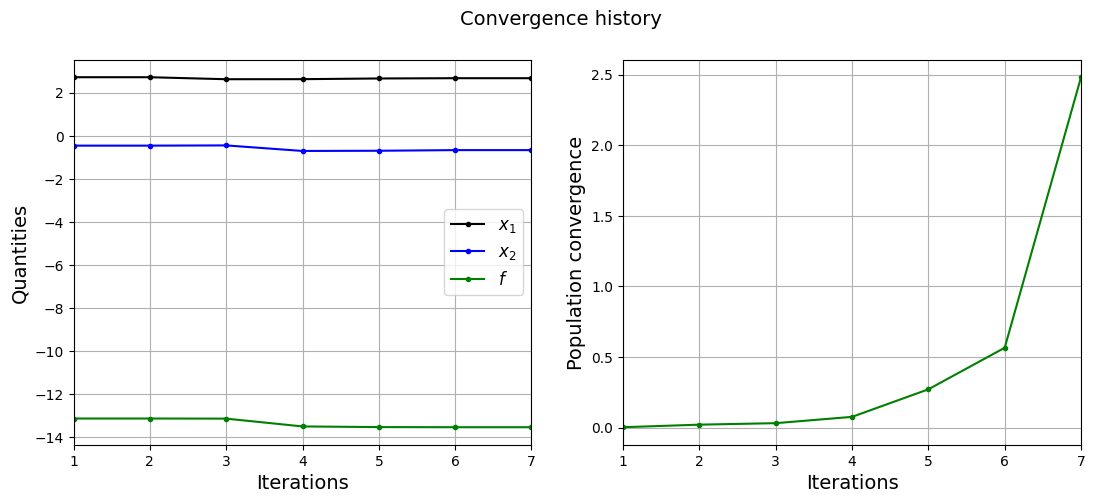

In [8]:
# Defining dict for storing history of optimization
history = {}
history["x1"] = []
history["x2"] = []
history["f"] = []
history["convergence"] = []

# Bounds
bounds = [(-2,4), (-2,4)]

# There are various paramters which can be set for differential evolution.
# Please check the documentation
result = optimize.differential_evolution(jones_function, disp=True, bounds=bounds, init="latinhypercube", callback=jones_global_opt_history)

# Print value of x
print("Value of x1 at optimum: {}".format(result.x[0]))
print("Value of x2 at optimum: {}".format(result.x[1]))
print("Function value at optimum: {}".format(jones_function(result.x)))

# Convergence plots
jones_func_global_opt_plots(history)

*First* plot shows the best solution in each iteration. *Second* plot shows the fractional value of population convergence. As soon as this value goes above 1.0, optimization is terminated. Also, when you run above block of code once again, you will notice that convergence history changes slightly which shows that there is some randomness in the algorithm. Most global optimization algorithm have some kind of randomness in their method, so it is always advised to run the optimization few times to ensure that you get more or less the same answer everytime.